# Определение стоимости автомобилей

### Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.



## Подготовка данных

In [1]:
!pip install lightgbm
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from skopt import BayesSearchCV
from skopt.space import Integer, Real

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')
    
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Имеется датасет, содержащий 16 столбцов и 354369 строк. При первичном осмотре данных можно увидеть следующие проблемы:
1. Столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` содержат пропуски.
2. Столбцы `DateCrawled`, `DateCreated`, `LastSeen` имеют тип `object`, а не `datetime`.
3. Численные данные имеют большую разрядность.
4. Названия столбцов записаны в CamelCase, а не в snake_case

### Изменение названий столбцов

In [4]:
re.sub(r"(\w)([[: upper:]])", r"\1_\2", "WordWordWordWord")

'Word_Word_Word_Word'

In [5]:
new_cols = {}
for i in range(len(df.columns)):
    col = re.sub(r"(\w)([[: upper:]])", r"\1_\2", df.columns[i])
    col = col.lower()
    new_cols[df.columns[i]] = col

new_cols

{'DateCrawled': 'date_crawled',
 'Price': 'price',
 'VehicleType': 'vehicle_type',
 'RegistrationYear': 'registration_year',
 'Gearbox': 'gearbox',
 'Power': 'power',
 'Model': 'model',
 'Kilometer': 'kilometer',
 'RegistrationMonth': 'registration_month',
 'FuelType': 'fuel_type',
 'Brand': 'brand',
 'NotRepaired': 'not_repaired',
 'DateCreated': 'date_created',
 'NumberOfPictures': 'number_of_pictures',
 'PostalCode': 'postal_code',
 'LastSeen': 'last_seen'}

In [6]:
df = df.rename(columns=new_cols)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Изменение типов данных

In [7]:
datetime_cols = ['date_crawled', 'date_created', 'last_seen']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    
df.info()    
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Понизим разрядность численных признаков.


In [8]:
int_cols = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures']
for col in int_cols:
    df[col] = pd.to_numeric(df[col], downcast='integer')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int16         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int16         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int16         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int32         
 8   registration_month  354369 non-null  int8          
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### Обработка пропусков и аномальных значений

На предыдущих шагах в глаза бросался тот факт, что у многих объявлений нет фотографий. Посмотрим, какие значения содержатся в этом столбце.

In [9]:
original_df = df
original_lenght = df.shape[0]
original_lenght

354369

In [10]:
sns.set(rc={'figure.figsize':(10, 7.5),
    'axes.labelsize':15,
    'xtick.labelsize':12,
    'ytick.labelsize':12,
})

In [11]:
df['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

Все значения в данном столбце - нули, то есть, ни у одной машины нет фото. Скорее всего, это ошибка при выгрузке данных, но т.к. возможности ее исправить нет, этот столбец в дальнейшем нам не нужен. Удалим его.

In [12]:
df = df.drop(columns='number_of_pictures')

In [13]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [14]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

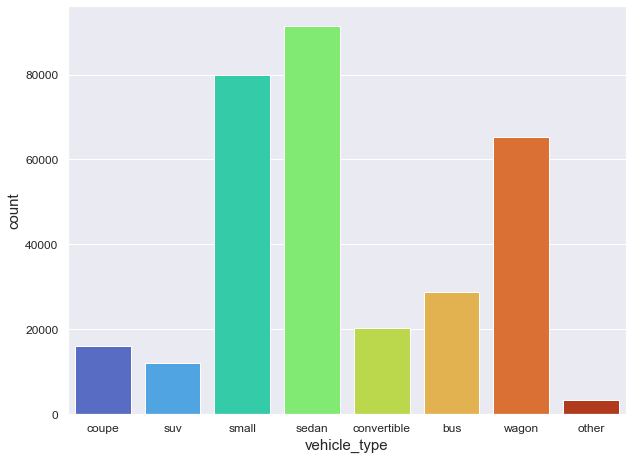

In [15]:
sns.countplot(x='vehicle_type', data=df, palette='turbo');

In [16]:
print(f'Процент пропусков от всех данных - {df["vehicle_type"].isna().sum() / len(df) :.2%}')

Процент пропусков от всех данных - 10.58%


In [17]:
df[(df['vehicle_type'].isna() == True) & (df['model'].isna() == False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,74579,2016-04-05 12:44:38
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,61169,2016-03-08 21:28:38
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,51371,2016-03-13 01:44:13


In [18]:
df[(df['brand']=='volkswagen') &
   (df['registration_year']==1993) &
   (df['model']=='golf')]['vehicle_type'].value_counts()

sedan          252
small          180
convertible     78
wagon           20
coupe           12
other            1
bus              1
Name: vehicle_type, dtype: int64

Пропусков в типе кузова более 10% - это достаточно много, поэтому удалять их нельзя. 

Вообще, большую часть пропусков в данном столбце можно восстановить по фотографиям, либо по марке и модели автомобиля. Однако, т.к. фотографий у нас в наличии нет, а у одной и той же модели авто могут быть разные кузова, такой подход нецелесообразен. Поэтому лучше заполнить пропуски значением заглушкой, например `Not Stated`.

In [19]:
df['vehicle_type'] = df['vehicle_type'].fillna('not stated')

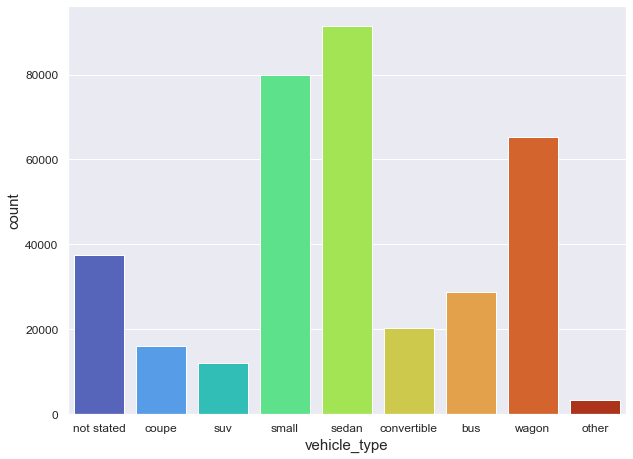

In [20]:
sns.countplot(x='vehicle_type', data=df, palette='turbo');

In [21]:
df[df['model'].isna() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,38709,2016-04-05 20:17:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,91186,2016-03-17 08:16:25
354338,2016-03-31 19:52:33,180,not stated,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,41470,2016-04-06 14:18:04
354351,2016-03-11 23:40:32,1900,not stated,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,87700,2016-03-12 14:16:51


In [22]:
f"Процент объявлений без указания модели авто - {df[df['model'].isna() == True].shape[0] / len(df) :.2%}"

'Процент объявлений без указания модели авто - 5.56%'

Пропусков в моделях авто меньше, чем в типах кузова - всего 5,4%. 

Восстановить пропущенные значения по другим данным в этом случае так же проблематично. А т.к. модель авто часто является одним из ключевых факторов при выборе автомобиля, неточные данные могут исказить качество модели в дальнейшем. Поэтому в данном случае пропуски лучше удалить.

In [23]:
df = df.dropna(subset=['model']).reset_index(drop=True)
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334664 entries, 0 to 334663
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        334664 non-null  datetime64[ns]
 1   price               334664 non-null  int16         
 2   vehicle_type        334664 non-null  object        
 3   registration_year   334664 non-null  int16         
 4   gearbox             318962 non-null  object        
 5   power               334664 non-null  int16         
 6   model               334664 non-null  object        
 7   kilometer           334664 non-null  int32         
 8   registration_month  334664 non-null  int8          
 9   fuel_type           308932 non-null  object        
 10  brand               334664 non-null  object        
 11  not_repaired        272564 non-null  object        
 12  date_created        334664 non-null  datetime64[ns]
 13  postal_code         334664 no

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox               15702
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             25732
brand                     0
not_repaired          62100
date_created              0
postal_code               0
last_seen                 0
dtype: int64

In [24]:
df[(df['brand']=='volkswagen') &
   (df['registration_year']==1993) &
   (df['model']=='golf')]['gearbox'].value_counts()

manual    456
auto       82
Name: gearbox, dtype: int64

In [25]:
df[(df['brand']=='volkswagen') &
   (df['registration_year']==1993) &
   (df['model']=='golf')]['fuel_type'].value_counts()

petrol      480
gasoline     13
lpg           5
Name: fuel_type, dtype: int64

Теперь, основываясь на модели и годе выпуска авто, можно заполнить пропуски столбцах `gearbox` и `fuel_type` используя наиболее частое значение.

In [26]:
for col in ['gearbox', 'fuel_type', 'vehicle_type']:
    df[col] = df[col].fillna(df.groupby(['brand','model'])[col].transform(lambda x: pd.Series.mode(x)[0]))

In [27]:
df['not_repaired'].value_counts()

no     238855
yes     33709
Name: not_repaired, dtype: int64

In [28]:
df['not_repaired'].isna().sum()

62100

In [29]:
df[(df['not_repaired'].isna()==True)].head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,not stated,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
7,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,94505,2016-04-04 23:42:13
8,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-17,27472,2016-03-31 17:17:06
11,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15,37269,2016-04-01 13:16:16
14,2016-03-11 21:39:15,450,small,1910,manual,0,ka,5000,0,petrol,ford,NaN,2016-03-11,24148,2016-03-19 08:46:47
15,2016-04-01 12:46:46,300,not stated,2016,manual,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
30,2016-03-29 16:57:02,899,not stated,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,37075,2016-03-29 17:43:07
35,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,petrol,opel,NaN,2016-03-11,2943,2016-04-07 03:46:09
39,2016-03-26 22:06:17,0,not stated,1990,manual,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,56412,2016-03-27 17:43:34


В случае с пропусками в столбце `not_repaired`, то логично предположить, что пропуск означает, что машина не была в ремонте, то есть на месте пропуска должно стоять `no`.
Помимо этого, для удобства заменим значения на численные.

In [30]:
df['not_repaired'] = df['not_repaired'].fillna(0)
df['not_repaired'] = df['not_repaired'].replace({'yes':1,'no':0})
print(df['not_repaired'].value_counts(), df.isna().sum(), sep='\n\n')

0    300955
1     33709
Name: not_repaired, dtype: int64

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
postal_code           0
last_seen             0
dtype: int64


Дальше взглянем на год выпуска авто.

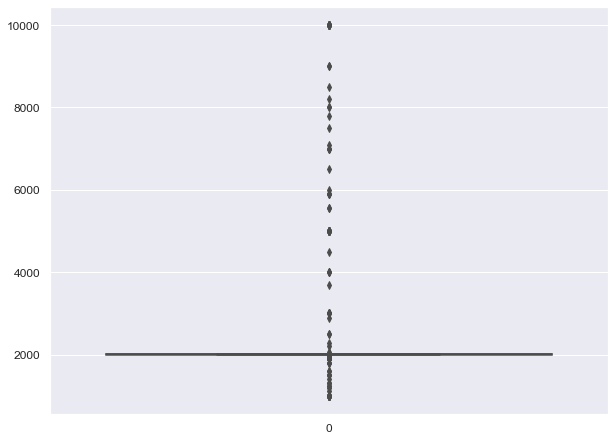

In [31]:
sns.boxplot(data=df['registration_year']);

In [32]:
sorted(df.query('registration_year > 2022')['registration_year'].unique())

[2066,
 2200,
 2290,
 2500,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,
 8500,
 9000,
 9999]

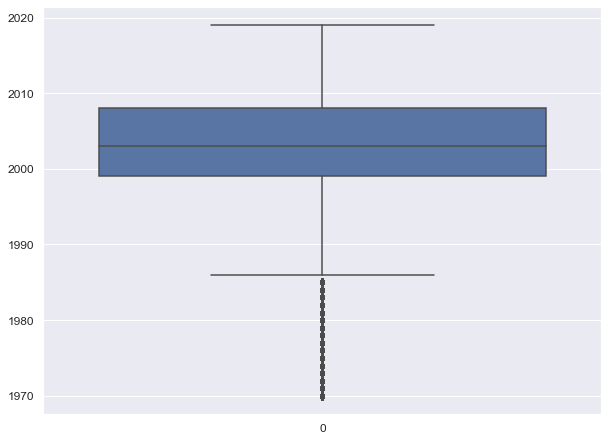

In [33]:
sns.boxplot(data=df.query('registration_year >= 1970 and registration_year <= 2022')['registration_year']);

In [34]:
f'Процент аномалий по году выпуска - {df.query("registration_year < 1970 or registration_year > 2022").shape[0] / df.shape[0] :.2%}'

'Процент аномалий по году выпуска - 0.27%'

В годе выпуска авто есть очевидно ошибочные значения - больше текущего года, а так же меньше 1886 года, когда был в принципе изобретен первый автомобиль. Их можно без потерь удалить. 

Если судить по гистограмме, то авто, выпущенные до 1985 года, являются явными выбросами, однако машины более раннего производства все еще могут быть в ходу. Поэтому оставим в данных только машины, выпущенные после 1970 года.

In [35]:
df = df.query('registration_year >= 1970 and registration_year <= 2022').reset_index(drop=True)

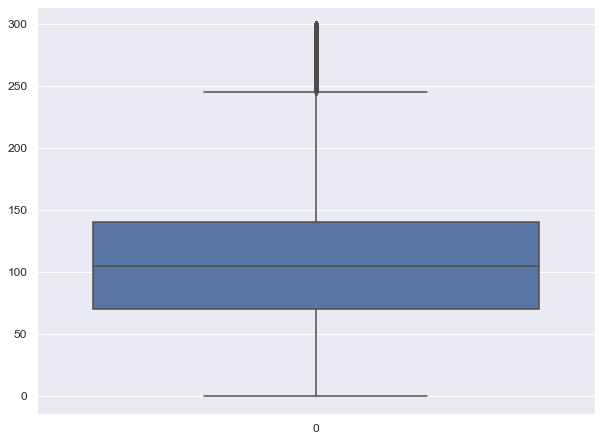

In [36]:
sns.boxplot(data=df.query('power < 300')['power']);

In [37]:
f'Процент машин с мощностью более 500 л.с. - {df.query("power > 500").shape[0] / original_lenght :.2%}'

'Процент машин с мощностью более 500 л.с. - 0.11%'

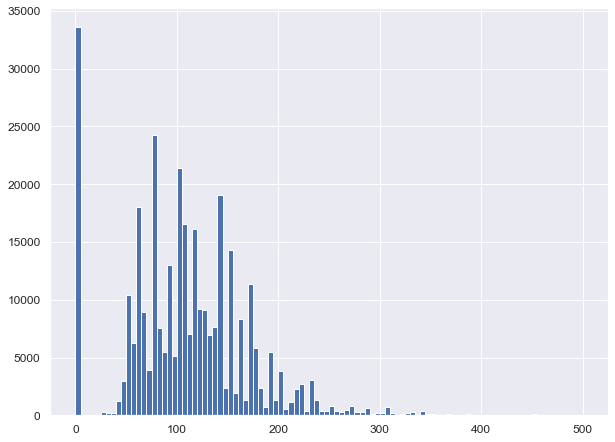

In [38]:
plt.hist(df.query('power <= 500')['power'], bins=100);

In [39]:
df.query('power <= 500')['power'].describe()

count    333359.000000
mean        108.034683
std          61.890554
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max         500.000000
Name: power, dtype: float64

In [40]:
df['power'].describe()

count    333749.000000
mean        111.473856
std         185.005408
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

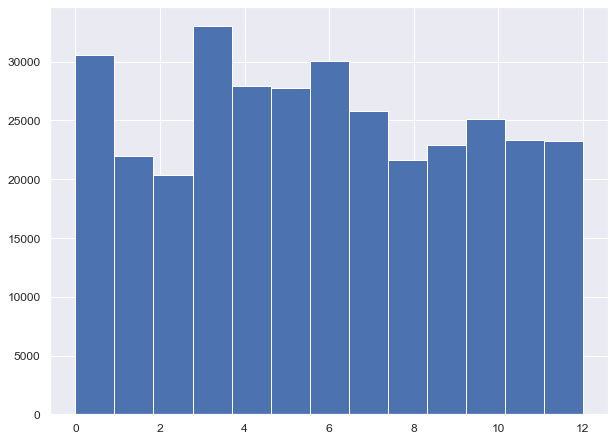

In [41]:
plt.hist(df['registration_month'], bins=len(df['registration_month'].unique()));

In [42]:
df['kilometer'].describe()

count    333749.000000
mean     128719.007398
std       37029.569300
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

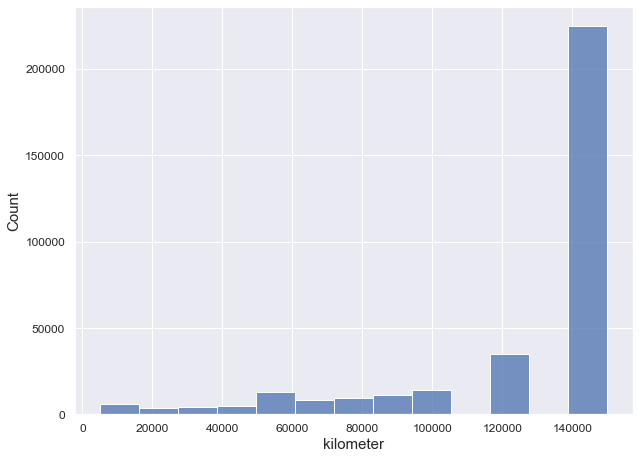

In [43]:
sns.histplot(data=df['kilometer'], bins=len(df['kilometer'].unique()));

В столбцах с информацией о мощности и месяце выпуска очень много значений, равных 0. Очивидно, что у нас не может быть ни нулевого месяца, ни машин с 0 л.с. Поэтому, данные нули мы так же заменим модой по модели и году выпуска.

Кроме того, в мощности есть очень большие значения, что так же является аномалиями. Для дальнейшей работы, оставим только автомобили с мощностью не более 500 л.с.

В столбце с пробегом большая часть данных имеет значение в 150000 км. Однозначно сказать, что это аномалия нельзя - возможно, это какое-то ограничение сайта с объявлениями. В любом случае, чем-то заменить это значение мы не можем. Нулевых значений в данном столбце нет.

In [44]:
df.groupby(['model','registration_year'])['power'].transform(lambda x: int(x.median()))

0          75
1         150
2         101
3          80
4         116
         ... 
333744    101
333745     95
333746     54
333747    102
333748    101
Name: power, Length: 333749, dtype: int16

In [45]:
for col in ['power', 'registration_month']:
    df.loc[df[col]==0, col] = df.groupby(['model','registration_year'])[col].transform(lambda x: int(x.median()))
    
df = df.query('power <= 500 and power != 0 and registration_month != 0').reset_index(drop=True)

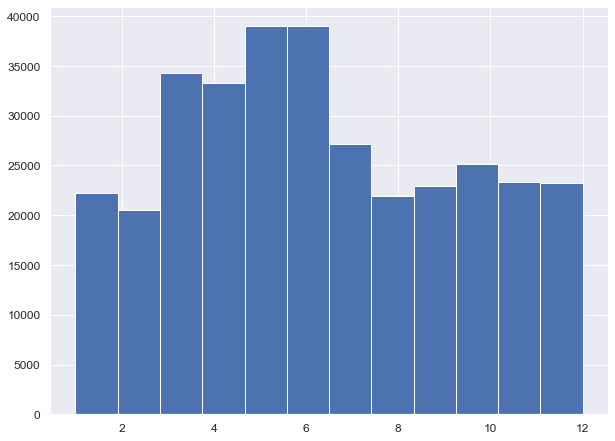

In [46]:
plt.hist(df['registration_month'], bins=len(df['registration_month'].unique()));

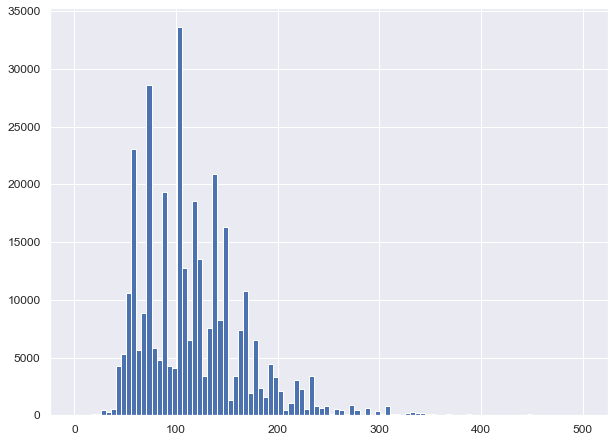

In [47]:
plt.hist(df['power'], bins=100);

Нулевые значения устранены.

Теперь взглянем на стоимость.

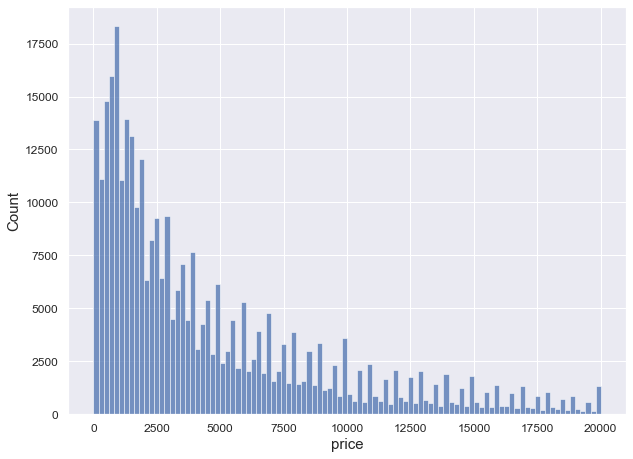

In [48]:
sns.histplot(data=df['price'], bins=100);

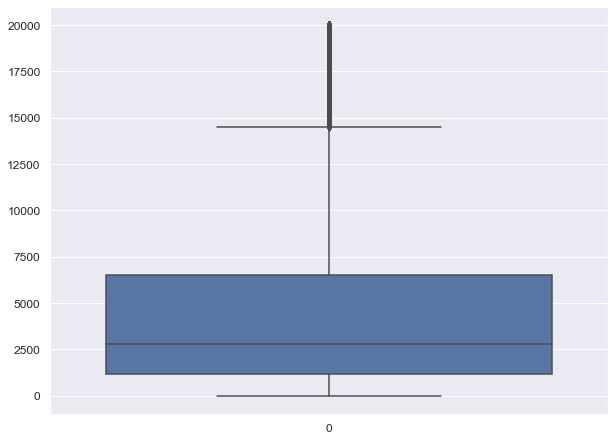

In [49]:
sns.boxplot(data=df['price']);

In [50]:
df['price'].describe()

count    332164.000000
mean       4505.597383
std        4524.764025
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [51]:
f'Процент объявлений с со стоимостью равной 0 - {df.query("price == 0").shape[0] / original_lenght :.2%}' 

'Процент объявлений с со стоимостью равной 0 - 2.36%'

In [52]:
df = df.query("price != 0").reset_index(drop=True)

f'При обработке было удалено {1 - df.shape[0] / original_lenght :.2%} данных'

'При обработке было удалено 8.62% данных'

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323814 entries, 0 to 323813
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        323814 non-null  datetime64[ns]
 1   price               323814 non-null  int16         
 2   vehicle_type        323814 non-null  object        
 3   registration_year   323814 non-null  int16         
 4   gearbox             323814 non-null  object        
 5   power               323814 non-null  int16         
 6   model               323814 non-null  object        
 7   kilometer           323814 non-null  int32         
 8   registration_month  323814 non-null  int8          
 9   fuel_type           323814 non-null  object        
 10  brand               323814 non-null  object        
 11  not_repaired        323814 non-null  int64         
 12  date_created        323814 non-null  datetime64[ns]
 13  postal_code         323814 no

In [54]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
postal_code           0
last_seen             0
dtype: int64

На этом предобработка закончена.

## Обучение моделей

### Подготовка выборок

Перед обучением моделей нужно закодировать данные, выделить таргет и фичи, а так же разбить данные на обучающую и тестовую выборки.

In [55]:
cols_to_encode = ['vehicle_type','gearbox','model','fuel_type','brand']
encoder = OrdinalEncoder()
df[cols_to_encode] = pd.DataFrame(encoder.fit_transform(df[cols_to_encode]), columns=df[cols_to_encode].columns)
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,3.0,1993,1.0,75,116.0,150000,5,6.0,37.0,0,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800,7.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0,2016-03-14,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,6.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0,2016-03-17,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,6.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0,2016-03-31,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,5.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1,2016-04-04,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323809,2016-03-19 19:53:49,3200,5.0,2004,1.0,225,140.0,150000,5,6.0,30.0,1,2016-03-19,96465,2016-03-19 20:44:43
323810,2016-03-27 20:36:20,1150,0.0,2000,1.0,101,248.0,150000,3,6.0,24.0,0,2016-03-27,26624,2016-03-29 10:17:23
323811,2016-03-05 19:56:21,1199,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,0,2016-03-05,26135,2016-03-11 18:17:12
323812,2016-03-19 18:57:12,9200,0.0,1996,1.0,102,223.0,150000,3,2.0,37.0,0,2016-03-19,87439,2016-04-07 07:15:26


In [56]:
for col in ['date_crawled', 'date_created', 'last_seen']:
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_time'] = df[col].dt.second + 60*(df[col].dt.minute + 60*df[col].dt.hour)
    df = df.drop(columns=[col])
    
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,...,date_crawled_day,date_crawled_time,date_created_year,date_created_month,date_created_day,date_created_time,last_seen_year,last_seen_month,last_seen_day,last_seen_time
0,480,3.0,1993,1.0,75,116.0,150000,5,6.0,37.0,...,24,42737,2016,3,24,0,2016,4,7,11817
1,9800,7.0,2004,0.0,163,117.0,125000,8,2.0,14.0,...,14,46341,2016,3,14,0,2016,4,5,46066
2,1500,6.0,2001,1.0,75,116.0,150000,6,6.0,37.0,...,17,60844,2016,3,17,0,2016,3,17,63617
3,3600,6.0,2008,1.0,69,101.0,90000,7,2.0,31.0,...,31,62720,2016,3,31,0,2016,4,6,37041
4,650,5.0,1995,1.0,102,11.0,150000,10,6.0,2.0,...,4,63383,2016,4,4,0,2016,4,6,69427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323809,3200,5.0,2004,1.0,225,140.0,150000,5,6.0,30.0,...,19,71629,2016,3,19,0,2016,3,19,74683
323810,1150,0.0,2000,1.0,101,248.0,150000,3,6.0,24.0,...,27,74180,2016,3,27,0,2016,3,29,37043
323811,1199,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,...,5,71781,2016,3,5,0,2016,3,11,65832
323812,9200,0.0,1996,1.0,102,223.0,150000,3,2.0,37.0,...,19,68232,2016,3,19,0,2016,4,7,26126


In [57]:
target = df['price']
features = df.drop(columns=['price'])

In [58]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

print(features_train.shape, target_train.shape, features_test.shape, target_test.shape, sep='\n')

(242860, 23)
(242860,)
(80954, 23)
(80954,)


### Обучение моделей

Перед обучением создадим словарь, куда будем вносить данные о результатах обучения моделей.

In [59]:
modeling_results = {
    'model':[],
    'name':[],
    'params':[],
    'RMSE':[],
    'time':[],
    'seconds':[],
}

#### Линейная регрессия

In [60]:
%%timeit -n1 -r1 -o 
sum(range(1000000))

model = LinearRegression()
score = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=4)
print(f'RMSE модели {type(model).__name__} - {abs(score.mean())}')

modeling_results['model'].append(model)
modeling_results['name'].append(type(model).__name__)
modeling_results['params'].append(model.get_params(deep=True))
modeling_results['RMSE'].append(abs(score.mean()))

RMSE модели LinearRegression - 2936.1802577200665
6.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 6.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [61]:
execution_time = _

modeling_results['time'].append(execution_time)
modeling_results['seconds'].append(execution_time.timings[0])

#### Случайный лес

In [62]:
%%timeit -n1 -r1 -o 
sum(range(1000000))

model = RandomForestRegressor(random_state=42)
model_params = {
        'n_estimators':Integer(10, 200),
        'max_depth':Integer(1, 11),
        'min_samples_split':Integer(2, 8),
             }

bs_rfr = BayesSearchCV(model, model_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4, n_iter=10, verbose=10)
bs_rfr.fit(features_train, target_train)

print(f'RMSE модели {type(model).__name__} - {abs(bs_rfr.best_score_)}')

modeling_results['model'].append(bs_rfr.best_estimator_)
modeling_results['name'].append(type(model).__name__)
modeling_results['params'].append(bs_rfr.get_params(deep=True))
modeling_results['RMSE'].append(abs(bs_rfr.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RMSE модели RandomForestRegressor - 1842.3033554637816
17min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 17min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [63]:
execution_time = _

modeling_results['time'].append(execution_time)
modeling_results['seconds'].append(execution_time.timings[0])

#### Gradient Boosting Regressor

In [64]:
%%timeit -n1 -r1 -o 
sum(range(1000000))

model = GradientBoostingRegressor(random_state=42)
model_params = {
        'n_estimators':Integer(20, 200),
        'max_depth':Integer(1, 11),
        'min_samples_split':Integer(2, 8),
             }

bs_gbr = BayesSearchCV(model, model_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4, n_iter=10, verbose=10)
bs_gbr.fit(features_train, target_train)

print(f'RMSE модели {type(model).__name__} - {abs(bs_gbr.best_score_)}')

modeling_results['model'].append(bs_gbr.best_estimator_)
modeling_results['name'].append(type(model).__name__)
modeling_results['params'].append(bs_gbr.get_params(deep=True))
modeling_results['RMSE'].append(abs(bs_gbr.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RMSE модели GradientBoostingRegressor - 1577.502770648988
15min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [65]:
execution_time = _

modeling_results['time'].append(execution_time)
modeling_results['seconds'].append(execution_time.timings[0])

#### CatBoost

In [66]:
%%timeit -n1 -r1 -o 
sum(range(1000000))

model = CatBoostRegressor(random_seed=42)
model_params = {
        'iterations':Integer(10, 200),
        'depth':Integer(1, 11),
        'l2_leaf_reg':Integer(2, 8),
             }

bs_cbr = BayesSearchCV(model, model_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4, n_iter=10, verbose=3)
bs_cbr.fit(features_train, target_train, verbose=10)

print(f'RMSE модели {type(model).__name__} - {abs(bs_cbr.best_score_)}')

modeling_results['model'].append(bs_cbr.best_estimator_)
modeling_results['name'].append(type(model).__name__)
modeling_results['params'].append(bs_cbr.get_params(deep=True))
modeling_results['RMSE'].append(abs(bs_cbr.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 4427.3959955	total: 202ms	remaining: 36.2s
10:	learn: 3629.9189057	total: 531ms	remaining: 8.15s
20:	learn: 3078.3991555	total: 852ms	remaining: 6.45s
30:	learn: 2699.7347698	total: 1.18s	remaining: 5.67s
40:	learn: 2444.5176647	total: 1.51s	remaining: 5.13s
50:	learn: 2268.2948423	total: 1.83s	remaining: 4.64s
60:	learn: 2146.3437527	total: 2.16s	remaining: 4.21s
70:	learn: 2058.0950961	total: 2.

<TimeitResult : 40 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [67]:
execution_time = _

modeling_results['time'].append(execution_time)
modeling_results['seconds'].append(execution_time.timings[0])

#### LigthGBM

In [68]:
%%timeit -n1 -r1 -o 
sum(range(1000000))

model = LGBMRegressor(random_state=42)
model_params = {
        'learning_rate':Real(1e-2, 1e+6, prior='log-uniform'),
        'n_estimators':Integer(10, 500),
        'max_depth':Integer(1, 11),
             }

bs_lgbm = BayesSearchCV(model, model_params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4, n_iter=10, verbose=3)
bs_lgbm.fit(features_train, target_train)

print(f'RMSE модели {type(model).__name__} - {abs(bs_lgbm.best_score_)}')

modeling_results['model'].append(bs_lgbm.best_estimator_)
modeling_results['name'].append(type(model).__name__)
modeling_results['params'].append(bs_lgbm.get_params(deep=True))
modeling_results['RMSE'].append(abs(bs_lgbm.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RMSE модели LGBMRegressor - 1742.516783146208
25.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 25.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [69]:
execution_time = _

modeling_results['time'].append(execution_time)
modeling_results['seconds'].append(execution_time.timings[0])

## Анализ моделей
### Оценка моделей

In [70]:
results = pd.DataFrame(modeling_results, columns=modeling_results.keys())
results

,model,name,params,RMSE,time,seconds
0,LinearRegression(),LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",2936.180258,6.85 s ± 0 ns per loop (mean ± std. dev. of 1 ...,6.849184
1,"(DecisionTreeRegressor(max_depth=11, max_featu...",RandomForestRegressor,"{'cv': 3, 'error_score': 'raise', 'estimator__...",1842.303355,17min 12s ± 0 ns per loop (mean ± std. dev. of...,1032.198494
2,([DecisionTreeRegressor(criterion='friedman_ms...,GradientBoostingRegressor,"{'cv': 3, 'error_score': 'raise', 'estimator__...",1577.502771,15min 12s ± 0 ns per loop (mean ± std. dev. of...,912.418395
3,<catboost.core.CatBoostRegressor object at 0x0...,CatBoostRegressor,"{'cv': 3, 'error_score': 'raise', 'estimator__...",1778.595758,40 s ± 0 ns per loop (mean ± std. dev. of 1 ru...,40.049194
4,LGBMRegressor(learning_rate=0.0294106526275636...,LGBMRegressor,"{'cv': 3, 'error_score': 'raise', 'estimator__...",1742.516783,25.9 s ± 0 ns per loop (mean ± std. dev. of 1 ...,25.901737


In [71]:
print('Лучшее RMSE -', results[results['RMSE']==results['RMSE'].min()]['name'])
print('Худшее RMSE -', results[results['RMSE']==results['RMSE'].max()]['name'])
print()
print('Лучшее время -', results[results['seconds']==results['seconds'].min()]['name'])
print('Худшее время -', results[results['seconds']==results['seconds'].max()]['name'])

Лучшее RMSE - 2    GradientBoostingRegressor
Name: name, dtype: object
Худшее RMSE - 0    LinearRegression
Name: name, dtype: object

Лучшее время - 0    LinearRegression
Name: name, dtype: object
Худшее время - 1    RandomForestRegressor
Name: name, dtype: object


In [72]:
top_rmse=results.sort_values(by=['RMSE'], ascending=True).reset_index(drop=True).loc[:1]
best_model = top_rmse[top_rmse['seconds']==top_rmse['seconds'].min()].reset_index(drop=True)
print(f'Лучшая модель - {best_model.loc[0,"name"]} с показателем RMSE {best_model.loc[0,"RMSE"] :.2f} и временем обучения {best_model.loc[0,"seconds"] :.1f} секунд')

Лучшая модель - LGBMRegressor с показателем RMSE 1742.52 и временем обучения 25.9 секунд


### Проверка лучшей модели

In [73]:
%%time

model = best_model.loc[0, 'model']
model.fit(features_train, target_train)
predict = model.predict(features_test)
score = mean_squared_error(target_test, predict, squared=False)
print('RMSE на тестовой выборке -', score)

RMSE на тестовой выборке - 1743.6839951608767
CPU times: total: 9.52 s
Wall time: 1.77 s


## Вывод

В ходе проекта были проведена работа по обучению и выбору лучшей модели для определения цены автомобиля по его характеристикам. Основными критериями для выбора модели были ее высокие скорость и качество.

1. Первым делом был проведен анализ имеющихся данных, который показал, что в исходном датасете имеются ошибки:
    1. В нескольких столбцах отсутсвовали значения
    2. Присутсвовали аномальные значения, такие как, например, год выпуска авто, который еще не наступил


2. В ходе предобработки часть пропущенных значений были удалены, т.к. не было возможности их корректно восстановить, другие пропуски были заполены либо значением-заглушкой, либо модой по Марке и Модели автомобилей. Такой же подход был применен для устранения аномалий. Всего было удалено около 8% исходных данных.

3. Далее было выполнено кодирование признаков, а так же выделение фич и таргета и их деление обучающие и тестовые выборки.

4. Были обучены 5 моделей: линейная регрессия, случайный лес и 3 модели градиентного бустинга. Самая быстрая модель - линейная регрессия, однако она показала худший результат RMSE Лучший результат RMSE показала модель GradientBoostingRegressor из модуля scikit-learn, однако она имеет очень большое время обучения. Наиболее подходящей для задачи моделью оказалась модель **LightGBM** - показатель RMSE близок к GBR, а время обучения всего около 30 секунд.